In [107]:
'''import zipfile
with zipfile.ZipFile('dogImages.zip', 'r') as zip_ref:
    zip_ref.extractall('dogBreedImages')'''

"import zipfile\nwith zipfile.ZipFile('dogImages.zip', 'r') as zip_ref:\n    zip_ref.extractall('dogBreedImages')"

In [108]:
'''with zipfile.ZipFile('lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw_faces')'''

"with zipfile.ZipFile('lfw.zip', 'r') as zip_ref:\n    zip_ref.extractall('lfw_faces')"

In [109]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from mtcnn.mtcnn import MTCNN

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
import tensorflow as tf

In [110]:

def clean_predictions(pred):
    '''
    transforms one hot encoding into classificatoin
    
    '''
    predsList = []
    for a in pred:
     
        predsList.append(np.argmax(a))
    predsList = np.array(predsList)
    return predsList

In this project I want to make a classifier that classifies and image as either a human face or a dog.  I it is a dog, another NN will give the breed of the dog.  If the image is a human, the NN will give the breed of dog that human most resembles.

### Input data

The data is thousands of images of dogs categorized by breed, and thousands of human faces categorized by the name of the person.  Traning, testing, and validation data has already been broken out for the dog images.

To solve this classification problem I am going to used several pretrained neural nets with dense layers added to the end,and see which pretrained neural nets work best.

The solution will be a web app that when an images is uploaded, it classifies the image as dog or human, then displays the dog breed, or the breed the human resembles.

### Metrics

I used accuracy and F1 score as metrics to get a complete understanding of model performance in the case that the test data was not balanced

### Data preprocessing

The data did not require much analysis other than determining how the folders were structure and the image file formats.

Some data processing was required to build the dog-or-human classifier.  I had to move lots of images into dog or human folders inside new training and testing data sets.  For the dog breeds the data was already organized and could be fed into an image generator

### Modeling

I used a number of different pretrained models and turened their training layers to false to build my models. I tried building a CNN from scratch but that didn't work well for dog breed classification.  I tried resnet50 for transferlearning but either underfit or overfit depending on the number of layers I left trainable. VGG19 have mediocre results.  The best results came from the Inception and Xception models.  I used Xception in my web app, which is very accurate. 

### Hyperparameters

for parameter tuning I tweaked the number of dense layers that were added to the pretrained models and the number of nodes in each layer.  I also tweake the dropout layers to prevent overfitting.  I also adjust the number of layers that we trainable in the pretrained models

The Xception and inception models got the best results, with Xception achieving and accuracy of 80% and 0.799 F1 score and Inception getting and accuracy of 79% and an F1 score of 0.793.  I used the xception model for classification data in the web app.

Using transfer learning of pretrained models is the most effective method of dog breed classification.  An improvemnt might be looking of new and improved pretrained image classification models.

### Create Human-Dog Classifier NN with Xception model transfer learning

In [111]:
imshape = (224, 224)

In [112]:
train_face_generator = ImageDataGenerator(
        
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

In [113]:
vald_face_generator =  ImageDataGenerator(rescale=1./255)

In [114]:
test_face_generator =  ImageDataGenerator(rescale=1./255)

In [115]:
face_train_dir = 'train_dog_face/Train'

face_test_dir = 'train_dog_face/Test'

face_val_dir ='train_dog_face/Valid'

In [116]:
face_train_data = train_face_generator.flow_from_directory(face_train_dir, target_size=imshape, shuffle=True,seed = 10,
                                                     class_mode='categorical', batch_size=64)



Found 19653 images belonging to 2 classes.


In [117]:
face_val_data = vald_face_generator.flow_from_directory(face_val_dir, target_size=imshape, shuffle=False, 
                                                     class_mode='categorical', batch_size=64)


Found 949 images belonging to 2 classes.


In [118]:
face_test_data = test_face_generator.flow_from_directory(face_test_dir, target_size=imshape, shuffle=False, 
                                                     class_mode='categorical', batch_size=64)


Found 982 images belonging to 2 classes.


In [119]:
epochs = 40
xcept = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (imshape[0], imshape[1], 3))

In [120]:
for num in range(len(xcept.layers[:131])):
    layer = xcept.layers[num]
    layer.trainable = False

In [121]:
x = xcept.output
x = AveragePooling2D(pool_size=(3,3))(x)

x = Flatten()(x)

x = Dense(2048, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(1024, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(512, activation = 'relu')(x)
x  = Dropout(0.4)(x)



pred = Dense(2, activation = 'softmax', kernel_initializer='random_uniform')(x)

In [122]:
modelXface =Model(inputs = xcept.input , outputs = pred)

In [123]:
modelXface.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])
modelXface.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [124]:
checkpointerXface = ModelCheckpoint(filepath='saved_models/weights.best.Xface.hdf5', 
                               verbose=1, save_best_only=True)

In [125]:
epochs = 2

histX  = modelXface.fit(face_train_data, callbacks = [checkpointerXface], epochs = epochs, validation_data = face_val_data, verbose = 1)

Epoch 1/2
308/308 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9924
Epoch 1: val_loss improved from inf to 0.00000, saving model to saved_models\weights.best.Xface.hdf5
308/308 [==============================] - 123s 393ms/step - loss: 0.0400 - accuracy: 0.9924 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
308/308 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9987
Epoch 2: val_loss did not improve from 0.00000
308/308 [==============================] - 118s 384ms/step - loss: 0.0219 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


### Accuracy of face-dog classifier with Xception net

In [126]:
accuracyXface = modelXface.evaluate(face_test_data)
accuracyXface

16/16 [==============================] - 2s 139ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [127]:
predXface = modelXface.predict(face_test_data)

16/16 [==============================] - 3s 133ms/step


In [128]:
predXface

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [23]:
modelXface.save('saved_models/Xface.h5')

In [24]:
predsListXface = clean_predictions(predXface)

In [25]:
precision_recall_fscore_support(face_test_data.labels,predsListXface, average = 'macro')

(0.9965986394557823, 0.9994019138755981, 0.9979942933356208, None)

In [26]:

train_generator = ImageDataGenerator(
        
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')


In [27]:
vald_generator =  ImageDataGenerator(rescale=1./255)

In [28]:
dog_train_dir = 'dogBreedImages/dogImages/dogImages/train'

dog_test_dir = 'dogBreedImages/dogImages/dogImages/test'

dog_val_dir = 'dogBreedImages/dogImages/dogImages/valid'


In [29]:
imshape = (224, 224)

In [30]:
dog_train_data = train_generator.flow_from_directory(dog_train_dir, target_size=imshape, shuffle=True,seed = 10,
                                                     class_mode='categorical', batch_size=64)



Found 6680 images belonging to 133 classes.


In [31]:
dog_val_data = vald_generator.flow_from_directory(dog_val_dir, target_size=imshape, shuffle=False, 
                                                     class_mode='categorical', batch_size=64)


Found 835 images belonging to 133 classes.


In [32]:
test_generator =  ImageDataGenerator(rescale=1./255)

In [33]:
dog_test_data = train_generator.flow_from_directory(dog_test_dir, target_size=imshape, shuffle=False, 
                                                     class_mode='categorical', batch_size=64)


Found 836 images belonging to 133 classes.


### Resnet 50 for dog breed classification

In [34]:
import tensorflow as tf

resM = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape = (imshape[0], imshape[1], 3))

In [35]:
for num in range(len(resM.layers[:150])): #[:173]
    layer = resM.layers[num]
    layer.trainable = False

Hyperparameters:  removed one dense layer
- changed dense layer to 512, average pooling size to 3,3 from 4,4
- changed dense layer to 64

- tried 3 dense layers
- tried vgg 19
- the model trained but was overfitting so I increased the dropout
- used exception net and got the best results
- increased dense layers to 1024, 512, and increased dropout to 0.5
- dense layers to 2048, 1024, dropout to 0.7 
- made 60 layers of Xception NN trainable
- made pretrained models untrainable, this reduced overfitting dramatically 
- tested different numbers of layers being trainable on resnet for over and underfitting

- used inception3 retraining none of the layers in the pretrained model, got immediate reults

- resnet50 was not useful without retraining, which caused it to overfit

In [36]:
x = resM.output
print(x.shape)
x = AveragePooling2D(pool_size=(3,3))(x)

#x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)

'''x = Dense(2048, activation = 'relu')(x)
x  = Dropout(0.2)(x)'''

x = Dense(1024, activation = 'relu')(x)
x  = Dropout(0.3)(x)


x = Dense(512, activation = 'relu')(x)
x  = Dropout(0.3)(x)

x = Dense(256, activation = 'relu')(x)
x  = Dropout(0.3)(x)


pred = Dense(133, activation = 'softmax', kernel_initializer='random_uniform')(x)

(None, 7, 7, 2048)


In [37]:
checkpointerRes = ModelCheckpoint(filepath='saved_models/weights.best.res50.hdf5', 
                               verbose=1, save_best_only=True)

earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='min', 
                              verbose=1, 
                              patience=10)  

In [38]:
with tf.device("/GPU:0"):


    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14250479576272765211
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14055112704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1075177813609644994
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:07:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [39]:
model2 =Model(inputs = resM.input , outputs = pred)

In [40]:
model2.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [41]:
epochs  = 25

hisotryR = model2.fit(dog_train_data, callbacks = [checkpointerRes, earlystopping], epochs = epochs, validation_data = dog_val_data, verbose = 1)

Epoch 1/25
105/105 [==============================] - ETA: 0s - loss: 4.8747 - accuracy: 0.0100
Epoch 1: val_loss improved from inf to 5.01774, saving model to saved_models\weights.best.res50.hdf5
105/105 [==============================] - 53s 479ms/step - loss: 4.8747 - accuracy: 0.0100 - val_loss: 5.0177 - val_accuracy: 0.0108
Epoch 2/25
105/105 [==============================] - ETA: 0s - loss: 4.7777 - accuracy: 0.0183
Epoch 2: val_loss improved from 5.01774 to 4.88121, saving model to saved_models\weights.best.res50.hdf5
105/105 [==============================] - 50s 480ms/step - loss: 4.7777 - accuracy: 0.0183 - val_loss: 4.8812 - val_accuracy: 0.0096
Epoch 3/25
105/105 [==============================] - ETA: 0s - loss: 4.7142 - accuracy: 0.0189
Epoch 3: val_loss improved from 4.88121 to 4.74892, saving model to saved_models\weights.best.res50.hdf5
105/105 [==============================] - 51s 488ms/step - loss: 4.7142 - accuracy: 0.0189 - val_loss: 4.7489 - val_accuracy: 0.0240

In [42]:
accuracy2 = model2.evaluate(dog_test_data)
accuracy2

14/14 [==============================] - 6s 411ms/step - loss: 4.4555 - accuracy: 0.0502


[4.455504894256592, 0.050239235162734985]

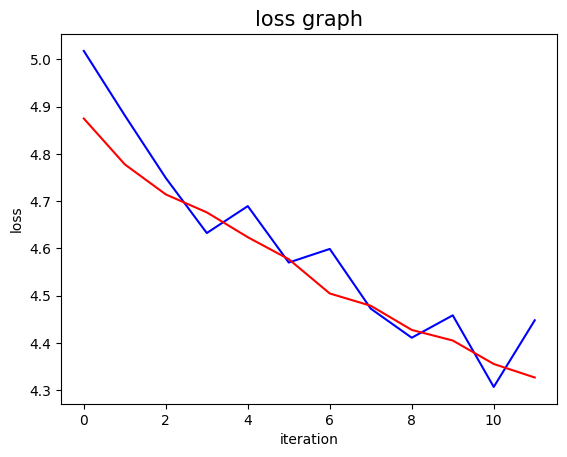

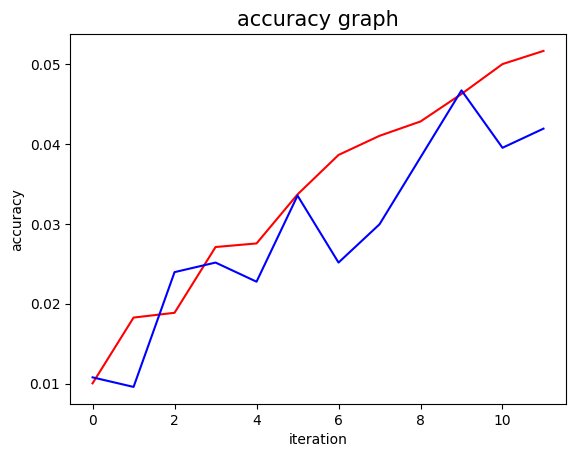

In [43]:
a = hisotryR.history


list_val_acc = a['val_accuracy']
list_acc = a['accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_acc, 'r-')
plt.plot(list_val_acc, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

### Xception model

In [44]:
epochs = 40
xcept = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (imshape[0], imshape[1], 3))
 

In [45]:
for num in range(len(xcept.layers[:130])):
    layer = xcept.layers[num]
    #print(layer.trainable)

In [46]:
print(len(xcept.layers[:-60]))

72


In [47]:
for num in range(len(xcept.layers[:131])):
    layer = xcept.layers[num]
    layer.trainable = False

In [48]:
len(xcept.layers)

132

In [49]:


x = xcept.output
x = AveragePooling2D(pool_size=(3,3))(x)

x = Flatten()(x)

x = Dense(2048, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(1024, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(512, activation = 'relu')(x)
x  = Dropout(0.4)(x)



pred = Dense(133, activation = 'softmax', kernel_initializer='random_uniform')(x)

In [50]:
modelXcept =Model(inputs = xcept.input , outputs = pred)

In [51]:
modelXcept.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])
modelXcept.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [52]:
checkpointerXcept = ModelCheckpoint(filepath='saved_models/weights.best.Xcept.hdf5', 
                               verbose=1, save_best_only=True)

In [53]:
epochs = 40

histX  = modelXcept.fit(dog_train_data, callbacks = [checkpointerXcept], epochs = epochs, validation_data = dog_val_data, verbose = 1)

Epoch 1/40
105/105 [==============================] - ETA: 0s - loss: 2.9440 - accuracy: 0.3400
Epoch 1: val_loss improved from inf to 0.96189, saving model to saved_models\weights.best.Xcept.hdf5
105/105 [==============================] - 54s 496ms/step - loss: 2.9440 - accuracy: 0.3400 - val_loss: 0.9619 - val_accuracy: 0.7257
Epoch 2/40
105/105 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.6296
Epoch 2: val_loss improved from 0.96189 to 0.77501, saving model to saved_models\weights.best.Xcept.hdf5
105/105 [==============================] - 51s 487ms/step - loss: 1.3254 - accuracy: 0.6296 - val_loss: 0.7750 - val_accuracy: 0.7689
Epoch 3/40
105/105 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.6981
Epoch 3: val_loss improved from 0.77501 to 0.76175, saving model to saved_models\weights.best.Xcept.hdf5
105/105 [==============================] - 51s 482ms/step - loss: 1.0772 - accuracy: 0.6981 - val_loss: 0.7617 - val_accuracy: 0.7665

### Exception results

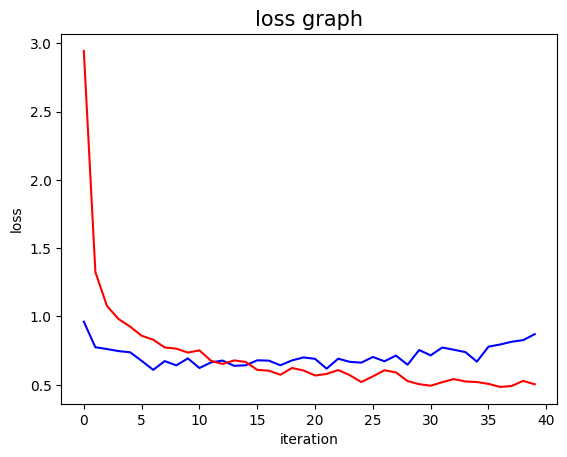

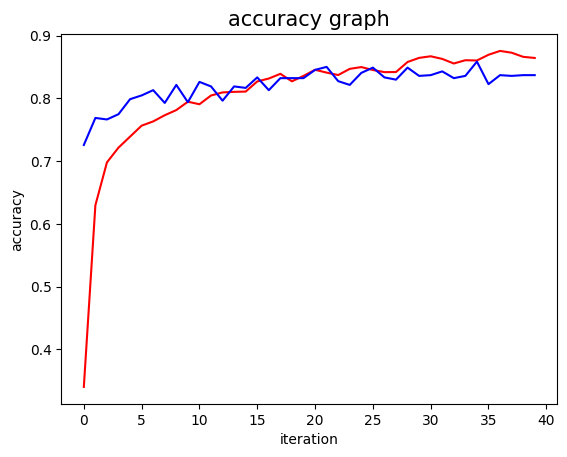

In [54]:
a = histX.history


list_val_acc = a['val_accuracy']
list_acc = a['accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_acc, 'r-')
plt.plot(list_val_acc, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [55]:
accuracyX = modelXcept.evaluate(dog_test_data)
accuracyX

14/14 [==============================] - 6s 419ms/step - loss: 0.9162 - accuracy: 0.8278


[0.916189432144165, 0.8277512192726135]

In [56]:
preds = modelXcept.predict(dog_test_data)

14/14 [==============================] - 6s 403ms/step


In [57]:
predsListX = clean_predictions(preds)

    

In [58]:
#precision_recall_fscore_support(dog_test_data.labels, predsList)

In [59]:
f1_score(dog_test_data.labels, predsListX, average = 'macro')

0.8077456360767191

In [60]:
precision_recall_fscore_support(dog_test_data.labels, predsListX, average = 'macro')

(0.8446277406803723, 0.8083333333333332, 0.8077456360767191, None)

In [61]:
modelXcept.save('saved_models/BreedXcept.h5')

### VGG19 model

In [62]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape = (imshape[0], imshape[1], 3))

In [63]:
for num in range(len(vgg.layers[:-1])):
    layer = vgg.layers[num]
    layer.trainable = False

In [64]:
x = vgg.output
x = AveragePooling2D(pool_size=(3,3))(x)

x = Flatten()(x)



x = Dense(512, activation = 'relu')(x)
x  = Dropout(0.2)(x)

x = Dense(256, activation = 'relu')(x)
x  = Dropout(0.2)(x)



pred = Dense(133, activation = 'softmax', kernel_initializer='random_uniform')(x)

In [65]:
checkpointerVGG = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

In [66]:


modelvgg =Model(inputs = vgg.input , outputs = pred)

In [67]:
modelvgg.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])
modelvgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [68]:
epochs = 25
histVGG = modelvgg.fit(dog_train_data, callbacks = [checkpointerVGG], epochs = epochs, validation_data = dog_val_data, verbose = 1)

Epoch 1/25
105/105 [==============================] - ETA: 0s - loss: 4.8323 - accuracy: 0.0165
Epoch 1: val_loss improved from inf to 4.58627, saving model to saved_models\weights.best.VGG19.hdf5
105/105 [==============================] - 51s 472ms/step - loss: 4.8323 - accuracy: 0.0165 - val_loss: 4.5863 - val_accuracy: 0.0323
Epoch 2/25
105/105 [==============================] - ETA: 0s - loss: 4.3005 - accuracy: 0.0521
Epoch 2: val_loss improved from 4.58627 to 3.87251, saving model to saved_models\weights.best.VGG19.hdf5
105/105 [==============================] - 49s 471ms/step - loss: 4.3005 - accuracy: 0.0521 - val_loss: 3.8725 - val_accuracy: 0.1102
Epoch 3/25
105/105 [==============================] - ETA: 0s - loss: 3.7563 - accuracy: 0.1081
Epoch 3: val_loss improved from 3.87251 to 3.40564, saving model to saved_models\weights.best.VGG19.hdf5
105/105 [==============================] - 49s 470ms/step - loss: 3.7563 - accuracy: 0.1081 - val_loss: 3.4056 - val_accuracy: 0.1569

In [69]:
accuracyV = modelvgg.evaluate(dog_test_data)
accuracyV

14/14 [==============================] - 6s 422ms/step - loss: 2.5625 - accuracy: 0.3278


[2.5625457763671875, 0.32775118947029114]

In [70]:
preds = modelvgg.predict(dog_test_data)

14/14 [==============================] - 6s 403ms/step


### VGG19 results

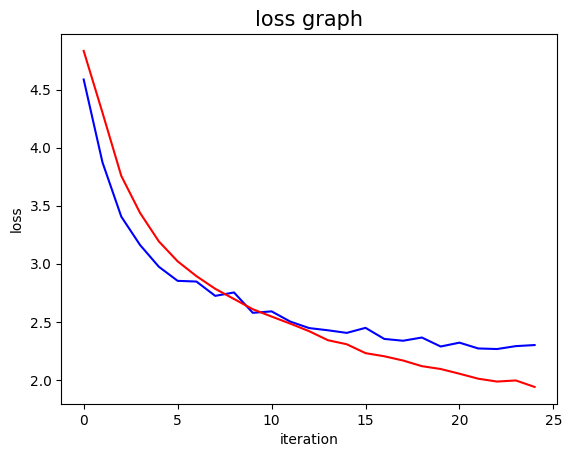

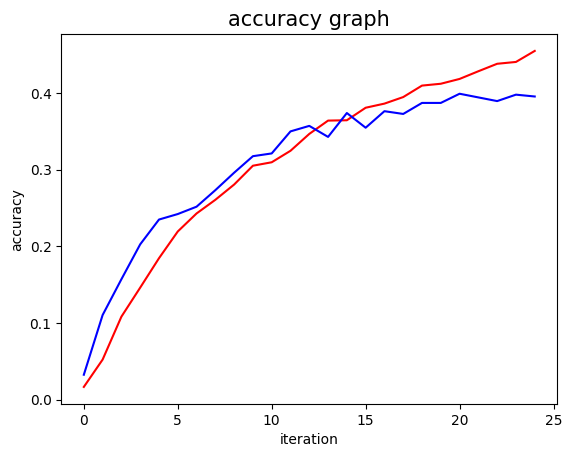

In [71]:
a = histVGG.history


list_val_acc = a['val_accuracy']
list_acc = a['accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_acc, 'r-')
plt.plot(list_val_acc, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

### Inception V3 model

In [72]:
inc = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape = (imshape[0], imshape[1], 3))



In [73]:
for num in range(len(inc.layers[:])):
    layer = inc .layers[num]
    layer.trainable = False

In [74]:
x = inc.output
x = AveragePooling2D(pool_size=(3,3))(x)

x = Flatten()(x)



x = Dense(1024, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(512, activation = 'relu')(x)
x  = Dropout(0.4)(x)

x = Dense(256, activation = 'relu')(x)
x  = Dropout(0.3)(x)



pred = Dense(133, activation = 'softmax', kernel_initializer='random_uniform')(x)

In [75]:
modelInc  =Model(inputs = inc.input , outputs = pred)

In [76]:
checkpointerInc = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

In [77]:
modelInc.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])
modelInc.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 111, 111, 32  96         ['conv2d_8[0][0]']               
 rmalization)                   )                                                           

In [78]:
epochs = 50
histInc = modelInc.fit(dog_train_data, callbacks = [checkpointerInc], epochs = epochs, validation_data = dog_val_data, verbose = 1)

Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: 3.6998 - accuracy: 0.2157
Epoch 1: val_loss improved from inf to 1.43548, saving model to saved_models\weights.best.Inception.hdf5
105/105 [==============================] - 54s 485ms/step - loss: 3.6998 - accuracy: 0.2157 - val_loss: 1.4355 - val_accuracy: 0.6407
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.5401
Epoch 2: val_loss improved from 1.43548 to 0.95973, saving model to saved_models\weights.best.Inception.hdf5
105/105 [==============================] - 49s 470ms/step - loss: 1.7539 - accuracy: 0.5401 - val_loss: 0.9597 - val_accuracy: 0.7377
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 1.3913 - accuracy: 0.6160
Epoch 3: val_loss improved from 0.95973 to 0.86567, saving model to saved_models\weights.best.Inception.hdf5
105/105 [==============================] - 50s 476ms/step - loss: 1.3913 - accuracy: 0.6160 - val_loss: 0.8657 - val_accu

### Inception model results

In [79]:
accuracyI = modelInc.evaluate(dog_test_data)
accuracyI

14/14 [==============================] - 6s 423ms/step - loss: 0.8795 - accuracy: 0.8038


[0.8795263767242432, 0.8038277626037598]

In [80]:
preds = modelInc.predict(dog_test_data)


14/14 [==============================] - 6s 396ms/step


In [81]:
predsListI = clean_predictions(preds)

In [82]:
#precision_recall_fscore_support(dog_test_data)
f1_score(dog_test_data.labels, predsListI, average = 'macro')

0.7863434332142868

In [83]:
precision_recall_fscore_support(dog_test_data.labels, predsListI, average = 'macro')

(0.813153554882878, 0.7912698412698413, 0.7863434332142868, None)

In [84]:
modelInc.save('saved_models/BreedInc.h5')

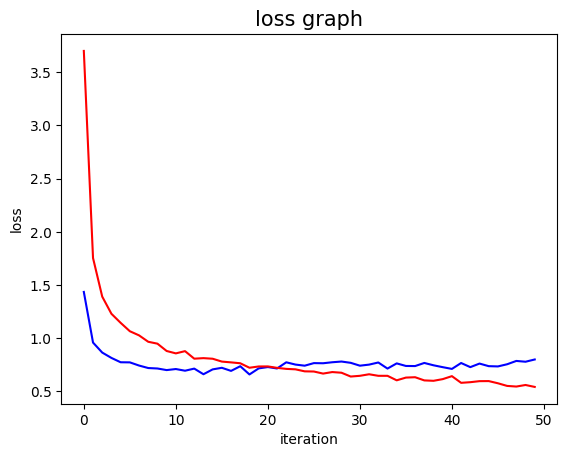

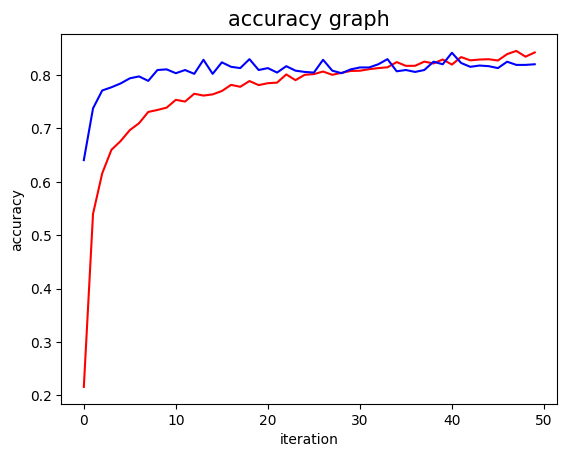

In [85]:
a = histInc.history


list_val_acc = a['val_accuracy']
list_acc = a['accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_acc, 'r-')
plt.plot(list_val_acc, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [86]:
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (imshape[0], imshape[1], 3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))



model.add(Flatten())

model.add(Dense(512))
model.add(Dropout(0.4))
model.add(Dense(256))
model.add(Dropout(0.3))

model.add(Dense(133, activation = 'softmax'))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer  = Adam(), metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_103 (Conv2D)         (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_104 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)      0

In [87]:
epochs = 55
#history = model.fit(dog_train_data, epochs = epochs, validation_data = dog_val_data, verbose = 1)

In [88]:
tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)